In [3]:
import pandas as pd
import os

data_folder = 'processed_data'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = {file: pd.read_csv(os.path.join(data_folder, file)) for file in csv_files}


In [34]:
col_to_remove = ['player_id', 'year']
columns = list(data_frames['players.csv'].columns)
for col in col_to_remove:
    if col in columns:    
        columns.remove(col)


In [43]:
columns

['overall_rating',
 'potential',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'preferred_foot_left',
 'preferred_foot_right']

In [4]:
# Function to extract player stats for home and away players from a single game
def get_player_stats(game_row, players_df):
    player_stats = []
    year = game_row['year']
    
    # Extract stats for home players
    for i in range(1, 12):
        home_player_id = game_row[f'home_player_{i}']
        home_player_stats = players_df[(players_df['player_id'] == home_player_id) & (players_df['year'] == year)]
        
        # Check if player exists in the dataset for the given year
        # If not, look for the most recent data available
        while year > 2008 and home_player_stats.empty:
            year -= 1
            home_player_stats = players_df[(players_df['player_id'] == home_player_id) & (players_df['year'] == year)]
        if not home_player_stats.empty:
            home_player_stats = home_player_stats.drop(columns=col_to_remove)
            player_stats.append(home_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 2))  # If no data, append zeroes

    # Extract stats for away players
    for i in range(1, 12):
        away_player_id = game_row[f'away_player_{i}']
        away_player_stats = players_df[(players_df['player_id'] == away_player_id) & (players_df['year'] == year)]
        
        # Check if player exists in the dataset for the given year
        # If not, look for the most recent data available
        while year > 2008 and away_player_stats.empty:
            year -= 1
            away_player_stats = players_df[(players_df['player_id'] == home_player_id) & (players_df['year'] == year)]
        if not away_player_stats.empty:
            away_player_stats = away_player_stats.drop(columns=col_to_remove)
            player_stats.append(away_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 2))  # If no data, append zeroes

    return player_stats



In [26]:
from sklearn.model_selection import train_test_split


home_players_formation = [f"home_player_X{i}" for i in range(1, 12)]
home_players_formation.extend([f"home_player_Y{i}" for i in range(1, 12)])
away_players_formation = [f"away_player_X{i}" for i in range(1, 12)]
away_players_formation.extend([f"away_player_Y{i}" for i in range(1, 12)])

# Load the datasets
# games = data_frames['games.csv']
games = data_frames['games.csv']
players = data_frames['players.csv']

# Prepare the features and labels (assuming 'home_team_win' as the target)
X = []
y = games['win_by'] 

# Extract features dynamically for each game
for index, game_row in games.iterrows():
    player_stats = get_player_stats(game_row, players)
    x_col = []
    x_col.extend([item for sublist in player_stats for item in sublist])
    x_col.extend([game_row[col] for col in home_players_formation])
    x_col.extend([game_row[col] for col in away_players_formation]) 
    X.append(x_col) 

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Train a model using RandomForestClassifier as an example
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by filling with the mean
    ('classifier', GradientBoostingClassifier())
])

pipeline.fit(X_train, y_train)
# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')


Model accuracy: 0.36


In [17]:
def get_player_stats_test(game_row, players_df):
    player_stats = []
    
    # Extract stats for home players
    for i in range(1, 12):
        home_player_id = game_row[f'home_player_{i}']
        home_player_stats = players_df[(players_df['player_id'] == home_player_id)]
        
        if not home_player_stats.empty:
            home_player_stats = home_player_stats.drop(columns=['player_id'])
            player_stats.append(home_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 1))  # If no data, append zeroes

    # Extract stats for away players
    for i in range(1, 12):
        away_player_id = game_row[f'away_player_{i}']
        away_player_stats = players_df[(players_df['player_id'] == away_player_id)]
         
        if not away_player_stats.empty:
            away_player_stats = away_player_stats.drop(columns=['player_id'])
            player_stats.append(away_player_stats.iloc[0])
        else:
            player_stats.append([0] * (players_df.shape[1] - 1))  # If no data, append zeroes

    return player_stats

In [18]:
predict_X = []

tests = data_frames["test.csv"]
player_mean = data_frames['players.csv'].groupby('player_id').mean().drop('year', axis=1).reset_index()

for index, test_row in tests.iterrows():
    player_stats = get_player_stats_test(test_row, player_mean)
    x_col = []
    x_col.extend([item for sublist in player_stats for item in sublist])
    x_col.extend([test_row[col] for col in home_players_formation])
    x_col.extend([test_row[col] for col in away_players_formation]) 
    predict_X.append(x_col) 

In [19]:
predict_res = pipeline.predict(predict_X)


In [45]:
X[-10:]

[[np.float64(68.0),
  np.float64(69.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(25.0),
  np.False_,
  np.True_,
  np.float64(67.0),
  np.float64(74.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(60.0),
  np.False_,
  np.True_,
  np.float64(63.0),
  np.float64(72.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(29.0),
  np.False_,
  np.True_,
  np.float64(70.0),
  np.float64(70.0),
  np.float64(0.0),
  np.float64(2.0),
  np.float64(44.0),
  np.True_,
  np.False_,
  np.float64(62.0),
  np.float64(65.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(64.0),
  np.True_,
  np.False_,
  np.float64(64.0),
  np.float64(70.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(55.0),
  np.False_,
  np.True_,
  np.float64(67.0),
  np.float64(67.0),
  np.float64(1.0),
  np.float64(2.0),
  np.float64(50.0),
  np.True_,
  np.False_,
  np.float64(65.0),
  np.float64(71.0),
  np.float64(2.0),
  np.float64(1.0),
  np.float64(60.0),
  np.False_,
  np.True_,
  np.float64(66.

In [50]:
feature_name = []
feature_name.extend([f"home_{c}_{i}" for i in range(1, 12) for c in columns])
feature_name.extend([f"away_{c}_{i}" for i in range(1, 12) for c in columns])
# feature_name.extend(home_players_formation)
# feature_name.extend(away_players_formation)
print(len(feature_name))


154


In [55]:
classifier = pipeline.named_steps['classifier']
feature_importances = classifier.feature_importances_
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_name,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.iloc[:50])

                    Feature  Importance
11          home_crossing_2    0.046959
53          home_crossing_8    0.035460
49    home_overall_rating_8    0.026499
50         home_potential_8    0.023360
95          away_crossing_3    0.021907
18          home_crossing_3    0.020497
91    away_overall_rating_3    0.018705
119   away_overall_rating_7    0.018415
81          away_crossing_1    0.017782
116         away_crossing_6    0.017660
36         home_potential_6    0.017624
39          home_crossing_6    0.016866
105   away_overall_rating_5    0.016166
70   home_overall_rating_11    0.015989
92         away_potential_3    0.015413
15         home_potential_3    0.015079
77    away_overall_rating_1    0.014627
25          home_crossing_4    0.014578
123         away_crossing_7    0.014249
74         home_crossing_11    0.014043
46          home_crossing_7    0.013738
57         home_potential_9    0.013474
133   away_overall_rating_9    0.013383
43         home_potential_7    0.013368


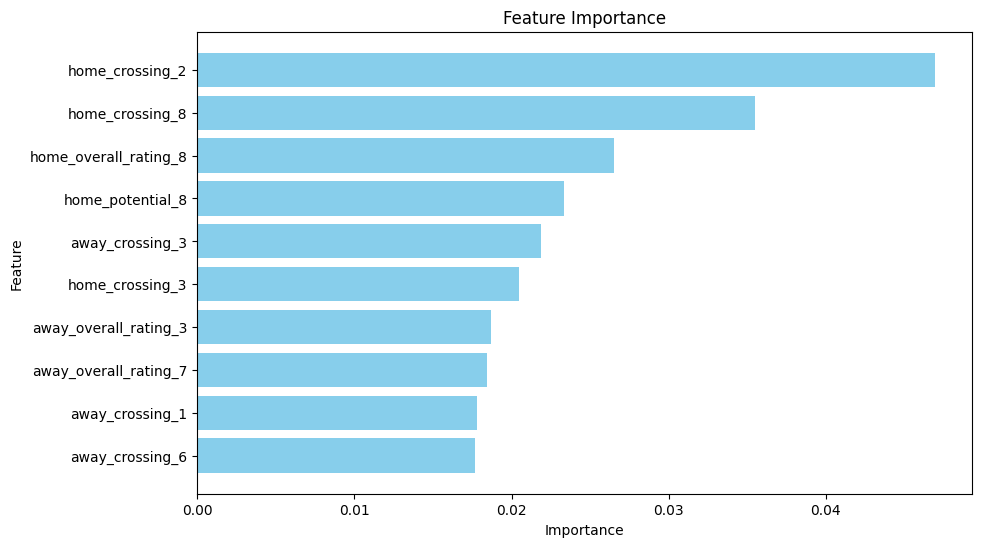

In [57]:
import matplotlib.pyplot as plt

# Assuming importance_df is already defined and contains 'Feature' and 'Importance' columns

importance_df = importance_df.iloc[:10]
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [21]:
df = pd.read_csv('data/example.csv')
df['winby'] = predict_res
df.to_csv('win_by_only.csv', index=False)